## Functions and imports

In [ ]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
import re
import os
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve, learning_curve
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Normalizer
from math import pi
from sklearn.pipeline import Pipeline
from xgboost.sklearn import XGBClassifier
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
sns.set()

In [20]:
def get_sites_dict_(data):
    '''
    Gets dataframe with site names (10 columns) as input.
    Returns a dictionary of sites ordered by frequency.
    '''
    m, n = data.shape #num of rows and columns
    data = pd.DataFrame(data.values.reshape(m*n, 1), columns=['site']) #transform to 1 column
    freq = data.site.value_counts().reset_index()
    key_value_df = pd.DataFrame() #contains a pair of site-frequency
    key_value_df['site'] = freq['index']
    key_value_df['count'] = freq['site']
    key_value_df.sort_values(by='count', inplace=True, ascending=False) 
    sites_dict = {} 
    sites_dict['Unknown'] = 0
    for i in np.arange(key_value_df.shape[0]):
        if key_value_df.iloc[i,0]!='Unknown':
            sites_dict[key_value_df.iloc[i,0]] = i+1
    return sites_dict

def inverse_dict(sites_dict):
    '''
    Gets a key-value dictionary. 
    Returns the dictionary by swapping the key and value.
    '''
    code_sites_dict = {}
    sites = list(sites_dict.items())
    for site in sites:
        code_sites_dict[site[1]] = site[0]
    return code_sites_dict

def make_sparse_data(data):
    '''
    Makes sparse matrix
    '''
    n = data.shape[1]
    X = data.values
    flatten_X = X.flatten()
    new_X = ([1]*flatten_X.shape[0], flatten_X, range(0, flatten_X.shape[0]+10, 10))
    X_sparse = csr_matrix(new_X)[:, 1:]
    return X_sparse

def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df=pd.DataFrame(predicted_labels,index=np.arange(1,predicted_labels.shape[0]+1),columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [21]:
def convert_time_to_feat(data):
    #1 - morning, 2 - day, 3 - evening
    if data.hour <= 11:
        return 1
    if data.hour > 11 and data.hour <= 17:
        return 2
    if data.hour >= 18 and data.hour <= 23:
        return 3
    
def compare_start_end(data):
    #Do the session have overlaps or not?
    if data['time_of_day_start'] == data['time_of_day_end']:
        return 1
    else: 
        return 0
    
def count_top_sites(session,top):
    #How many sites are in top-n sites given?
    session = session.values.flatten()
    if type(top) == set:
        top = list(top)
    else:
        top = [i[0] for i in top]    
    return len(np.where(np.isin(session,top) == True)[0])

def kmeansshow(k,X):

    from sklearn import cluster
    from matplotlib import pyplot

    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    #print centroids

    for i in range(k):
        # select only data observations with cluster label == i
        ds = X[np.where(labels==i)]
        # plot the data observations
        pyplot.plot(ds[:,0],ds[:,1],'o')
        # plot the centroids
        lines = pyplot.plot(centroids[i,0],centroids[i,1],'kx')
        # make the centroid x's bigger
        pyplot.setp(lines,ms=15.0)
        pyplot.setp(lines,mew=2.0)
    pyplot.legend()
    pyplot.show()
    return centroids

def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

## Here starts the game


### Open data, make basic transformations and preparations

In [2]:
with open('data/new_site_dict.pkl', 'rb') as input_file:
    site_dict = pickle.load(input_file)
    
train_df = pd.read_csv('data/train_df.csv',
                       index_col='session_id')
test_df = pd.read_csv('data/test_df.csv',
                      index_col='session_id')

sites = ['site%i' % i for i in range(1,11,1)]
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)
train_df = train_df.sort_values(by='time1')

# train_df = train_df.fillna(0)
# test_df = test_df.fillna(0)
train_df[sites] = train_df[sites].fillna(0).astype(int)
test_df[sites] = test_df[sites].fillna(0).astype(int)

# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

# Our target variable

y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_times = full_df[times]

### Creating features

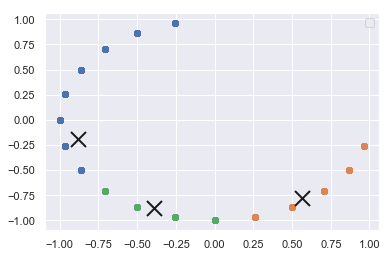

In [58]:
full_feats = pd.DataFrame()

#Extracting first site's domains from dictionary
# hosts = pd.read_pickle('data/site_dic.pkl')
# hosts = pd.DataFrame(data=list(hosts.keys()), index=list(hosts.values()), columns=['name']) # switch key and value

# hosts['split'] = hosts['name'].str.split('.')
# hosts['len'] = hosts['split'].map(lambda x: len(x)).astype(np.int8)
# hosts['domain'] = hosts['split'].map(lambda x: x[-1])

# hosts.drop(['name','split'], inplace=True, axis=1)
# hosts.index.rename('site1', inplace=True) # rename index for the future merge
# train_feats['domain'] = pd.merge(train_df, hosts, how='left', on='site1')['domain']

# ------------------ #


def add_time_features(df, X_sparse):
    hour = df['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    X = hstack([X_sparse, morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1), evening.values.reshape(-1, 1), 
                night.values.reshape(-1, 1)])
    return X



#Other time features
full_feats['start_month'] = full_df['time1'].apply(lambda x: x.month)
full_feats['end_month'] = time_df['max'].apply(lambda x: x.month)

full_feats['start_hour'] = full_df['time1'].apply(lambda x: x.hour)
full_feats['end_hour'] = time_df['max'].apply(lambda x: x.hour)
full_feats['hour_overlap'] = np.where(full_feats['start_hour'] == full_feats['end_hour'],0,1)

full_feats['time_of_day_start'] = full_df['time1'].apply(convert_time_to_feat)
full_feats['time_of_day_end'] = time_df['max'].apply(convert_time_to_feat)
full_feats['time_of_day_overlap'] = np.where(full_feats['time_of_day_start'] == full_feats['time_of_day_end'],0,1)

full_feats['start_day'] = full_df['time1'].apply(lambda x: x.day)
full_feats['end_day'] = time_df['max'].apply(lambda x: x.day)
full_feats['day_overlap'] = np.where(full_feats['start_day'] == full_feats['end_day'],0,1)

full_feats['start_day_of_week'] = full_df['time1'].apply(lambda x: x.weekday())
full_feats['end_day_of_week'] = time_df['max'].apply(lambda x: x.weekday())

full_feats['holiday'] = full_df['time1'].apply(lambda x: 1 if x.weekday() > 4 else 0)

full_feats['short_session'] = time_df['seconds'].apply(lambda x: 1 if x <= 25 else 0)

full_feats['morning'] = time_df['min'].apply(lambda x: 1 if x.hour >= 7 and x.hour <=11 else 0)
full_feats['day'] = time_df['min'].apply(lambda x: 1 if x.hour >= 12 and x.hour <= 18 else 0)
full_feats['evening'] = time_df['min'].apply(lambda x: 1 if x.hour >= 19 and x.hour <=23 else 0)
full_feats['night'] = time_df['min'].apply(lambda x: 1 if x.hour >= 0 and x.hour <=6 else 0)

# ------------------ #


#Cyclic time dependancy extraction

full_feats['hour_sin_x'] = full_feats.start_hour.apply(lambda ts: np.sin(2 * pi * ts/24.))
full_feats['hour_cos_x'] = full_feats.start_hour.apply(lambda ts: np.cos(2 * pi * ts/24.))

times = kmeansshow(3,full_feats[['hour_sin_x', 'hour_cos_x']].values)

full_feats['night_morning'] =np.linalg.norm(full_feats[['hour_sin_x', 'hour_cos_x']].values - times[0,:],axis=1)
full_feats['morning_day'] =np.linalg.norm(full_feats[['hour_sin_x', 'hour_cos_x']].values - times[1,:],axis=1)
full_feats['day_evening'] =np.linalg.norm(full_feats[['hour_sin_x', 'hour_cos_x']].values - times[2,:],axis=1)

# ------------------ #

#Sites features


# train_feats['domain'] = pd.merge(train_df, hosts, how='left', on='site1')['domain']
full_feats['max-min'] = full_df[sites].max(axis=1) - full_df[sites].min(axis=1)
full_feats['mean'] = full_df[sites].mean(axis=1)
full_feats['std'] = full_df[sites].std(axis=1)
full_feats['var'] = full_df[sites].var(axis=1)
full_feats['skew'] = full_df[sites].skew(axis=1)
full_feats['median'] = full_df[sites].median(axis=1)



# train_feats['target'] = train_df['target']


In [172]:
full_feats.to_csv('data/full_feats.csv')

## Looking for best site vectorizer

In [61]:
def sites_to_text(row):
    return ' '.join([str(x) for x in row])

full_feats['sites_text'] = full_sites.apply(lambda row: sites_to_text(row),axis=1)

In [118]:
%%time
from sklearn.pipeline import Pipeline
time_split = TimeSeriesSplit(n_splits = 10)
X_sites = full_feats.iloc[:idx_split]['sites_text']
pipe_count_log = Pipeline([
    ('vectorizer',CountVectorizer()),
    ('regressor',LogisticRegression(random_state = 42))
])
pars = {
    'vectorizer__ngram_range': [(1,1),(1,2),(1,3),(1,4)],
#     'vectorizer__analyzer': ['char_wb','word']
}
grid = GridSearchCV(pipe_count_log,pars,cv=time_split,scoring='roc_auc')
grid.fit(X_sites,y_train)

Wall time: 17min 33s


In [119]:
grid.best_score_,grid.best_params_

(0.8684632477303084, {'vectorizer__ngram_range': (1, 2)})

In [120]:
%%time
pipe_idf_log = Pipeline([
    ('vectorizer',TfidfVectorizer()),
    ('regressor',LogisticRegression(random_state = 42))
])
grid_2 = GridSearchCV(pipe_idf_log,pars,cv=time_split,scoring='roc_auc')
grid_2.fit(X_sites,y_train)

Wall time: 11min 19s


In [121]:
grid_2.best_score_,grid_2.best_params_

(0.8635576756856093, {'vectorizer__ngram_range': (1, 2)})

In [11]:
vectorizer = CountVectorizer(ngram_range = (1,2))
train_sites_sparse = vectorizer.fit_transform(full_feats.iloc[:idx_split]['sites_text'])
test_sites_sparse = vectorizer.transform(full_feats.iloc[idx_split:]['sites_text'])

## Choosing the best subset of features

In [ ]:
cv_split = TimeSeriesSplit(n_splits = 10)

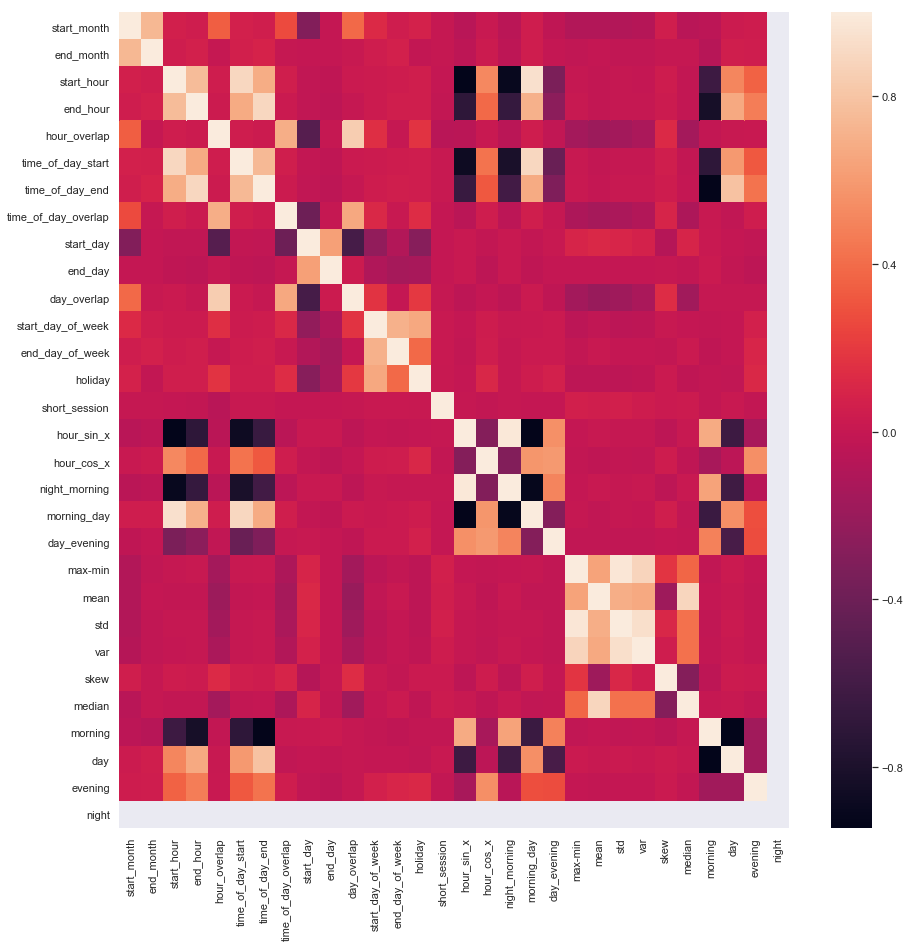

In [124]:
corr = full_feats.drop('sites_text',axis=1).corr()
top_corr_features = corr.index
plt.figure(figsize=(20,20))
sns.heatmap(corr,xticklabels = corr.columns,yticklabels = corr.columns,annot=True,cmap='RdYlGn')

### Sort features by importance via XGBClassifier

In [ ]:
%%time
X_train = full_feats.iloc[:idx_split].drop(['sites_text'],axis=1)
xgb = XGBClassifier(n_estimators = 100,random_state = 42)
xgb.fit(X_train,y_train)

In [171]:
importances_inds = xgb.feature_importances_.argsort()[::-1]

columns = full_feats.drop('sites_text',axis=1).columns[importances_inds]
columns

Index([u'max-min', u'start_day', u'start_day_of_week', u'median',
       u'hour_cos_x', u'day_evening', u'night_morning', u'start_month', u'day',
       u'mean', u'time_of_day_overlap', u'short_session', u'skew', u'end_hour',
       u'std', u'morning_day', u'hour_sin_x', u'holiday', u'end_day_of_week',
       u'var', u'day_overlap', u'end_day', u'evening', u'morning',
       u'time_of_day_end', u'time_of_day_start', u'hour_overlap',
       u'start_hour', u'end_month', u'night'],
      dtype='object')

In [136]:
X_train_scaled = StandardScaler().fit_transform(X_train)

In [150]:
%%time
cv_split = TimeSeriesSplit(n_splits = 10)
cols = []
res = []
for ind,col in enumerate(columns):
    cur_set = columns[:ind+1]
    cols.append(cur_set)
    inds = importances_inds[:ind+1]
    cur_data = csr_matrix(hstack((train_sites_sparse,X_train_scaled[:,inds])))
    result = cross_val_score(LogisticRegression(random_state=42),cur_data,y_train,cv=cv_split,scoring='roc_auc').mean()
    res.append(result)
    print 'Iter %i out of 26 is finished' % (ind + 1)

Iter 1 out of 26 is finished
Iter 2 out of 26 is finished
Iter 3 out of 26 is finished
Iter 4 out of 26 is finished
Iter 5 out of 26 is finished
Iter 6 out of 26 is finished
Iter 7 out of 26 is finished
Iter 8 out of 26 is finished
Iter 9 out of 26 is finished
Iter 10 out of 26 is finished
Iter 11 out of 26 is finished
Iter 12 out of 26 is finished
Iter 13 out of 26 is finished
Iter 14 out of 26 is finished
Iter 15 out of 26 is finished
Iter 16 out of 26 is finished
Iter 17 out of 26 is finished
Iter 18 out of 26 is finished
Iter 19 out of 26 is finished
Iter 20 out of 26 is finished
Iter 21 out of 26 is finished
Iter 22 out of 26 is finished
Iter 23 out of 26 is finished
Iter 24 out of 26 is finished
Iter 25 out of 26 is finished
Iter 26 out of 26 is finished
Iter 27 out of 26 is finished
Iter 28 out of 26 is finished
Iter 29 out of 26 is finished
Iter 30 out of 26 is finished
Wall time: 1h 3min 49s


### ROC-AUC score dependancy from number of features

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "picture.png")

In [152]:
np.argmax(res)

12

In [8]:
selected_feats = full_feats[columns[:13]]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(selected_feats.iloc[:idx_split])
X_test_scaled = scaler.transform(selected_feats.iloc[idx_split:])

### Tuning LogisticRegression

In [14]:
%%time
X_train_full = csr_matrix(hstack((train_sites_sparse,X_train_scaled)))
pars = {'C': np.logspace(-10,0,20)}
clf = LogisticRegression(random_state = 42)
grid_x = GridSearchCV(clf, pars, cv=cv_split,scoring='roc_auc',n_jobs=-1)
grid_x.fit(X_train_full,y_train)

Wall time: 4min 39s


In [16]:
print grid_x.best_params_, grid_x.best_score_

{'C': 0.08858667904100832} 0.9070421664053244


In [17]:
# from mlxtend.classifier import StackingClassifier
C_best = 0.08858667904100832

In [18]:
best_col_set = columns[:13]

### Making Predictions

In [22]:
train = csr_matrix(hstack((train_sites_sparse,X_train_scaled)))
test = csr_matrix(hstack((test_sites_sparse,X_test_scaled)))

clf = LogisticRegression(C=C_best, random_state=42)
clf.fit(train,y_train)

y_test = clf.predict_proba(test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'selected_features_attempt_1.csv')